In [1]:
# !pip install pystac-client
# !pip install odc-stac

  Using cached pystac_client-0.5.1-py3-none-any.whl (29 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.


In [2]:
# import pystac_client
# import odc.stac

In [3]:
# catalog = pystac_client.Client.open('https://explorer-aws.dea.ga.gov.au/stac')

In [9]:
# catalog

In [1]:
import datacube
dc = datacube.Datacube()

In [2]:
dss_ls5 = dc.find_datasets(product='ga_ls5t_ard_3')

In [3]:
dss_ls7 = dc.find_datasets(product='ga_ls7e_ard_3')

In [4]:
dss_ls8 = dc.find_datasets(product='ga_ls8c_ard_3')

In [5]:
dss_ls9 = dc.find_datasets(product='ga_ls9c_ard_3')

In [52]:
# dss_s2a = dc.find_datasets(product='ga_s2am_ard_3')

In [53]:
# dss_s2b = dc.find_datasets(product='ga_s2bm_ard_3')

In [6]:
dss = dss_ls5 + dss_ls7 + dss_ls8 + dss_ls9   #+ dss_s2a + dss_s2b

In [7]:
len(dss)

442930

/tmp/ipykernel_338/1869798562.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_df.groupby("odc:region_code").mean().plot.scatter(x="lon", y="lat", c="hour")


<Axes: xlabel='lon', ylabel='lat'>

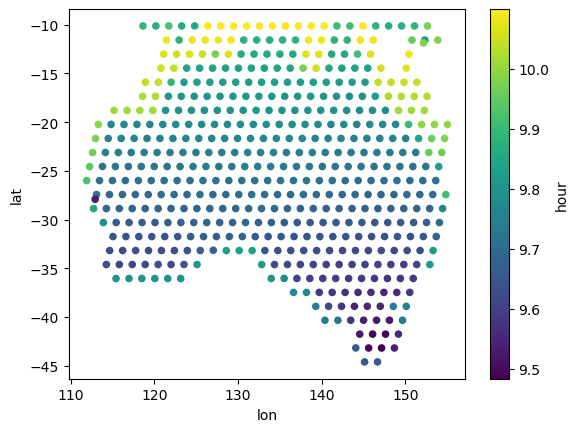

In [8]:
import datetime 
import pandas as pd
import numpy as np

def solar_time(dt, lon):
    """
    Returns an approximate true solar time (also known
    as local apparent time). This depends on longitude,
    increasing by one hour for each 15° westward of the
    prime meridian due to the earth's rotation.

    Solar noon for a given location indicates that the
    sun's direction is true north and its position is
    highest in the sky. It is not affected by local
    time-zones or daylight savings time.

    Solar time can be used to measure the local time at
    which a sun-synchronous satellite like Landsat passes
    overhead at a given location.
    """  
    
    return dt + datetime.timedelta(hours=(lon * 12 / 180))


metadata_df = pd.DataFrame([i.metadata_doc['properties'] for i in dss])
metadata_df['datetime'] = pd.to_datetime(metadata_df.datetime)
metadata_df['lat'] = [np.mean(list(i.metadata_doc['extent']['lat'].values())) for i in dss]
metadata_df['lon'] = [np.mean(list(i.metadata_doc['extent']['lon'].values())) for i in dss]
metadata_df['eo:platform'] = metadata_df['eo:platform'].replace('SENTINEL_2A', 'sentinel-2a')
metadata_df['eo:platform'] = metadata_df['eo:platform'].replace('SENTINEL_2B', 'sentinel-2b')
metadata_df["gqa_perc_good"] = metadata_df["gqa:abs_iterative_mean_xy"] < 1.0
metadata_df["gqa:abs_iterative_mean_xy"] = metadata_df["gqa:abs_iterative_mean_xy"].astype(float) * 25


local_time = metadata_df.apply(lambda x: solar_time(x.datetime, x.lon), axis=1)
metadata_df["hour"] = local_time.dt.hour + local_time.dt.minute / 60
metadata_df.groupby("odc:region_code").mean().plot.scatter(x="lon", y="lat", c="hour")


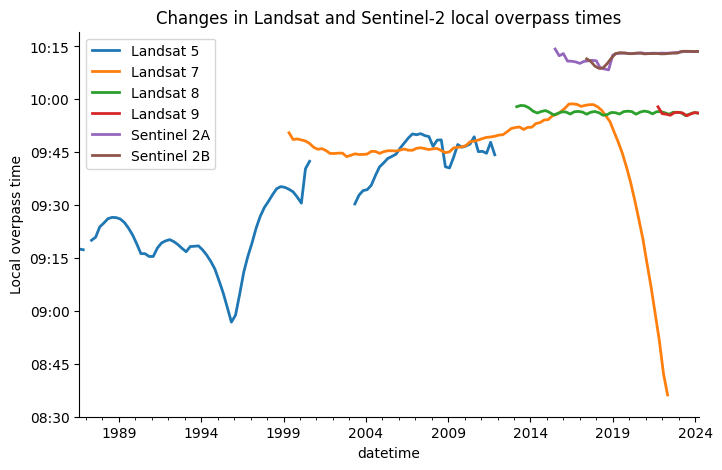

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the custom formatter function
def time_formatter(x, pos):
    hours = int(x)
    minutes = int((x - hours) * 60)
    return '{:02d}:{:02d}'.format(hours, minutes)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
# metadata_df.set_index('datetime').resample('3M').mean()['hour'].plot(c='black', linewidth=0.2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-5', ["datetime", "hour"]].set_index('datetime').resample('3M').mean()['hour'].rename('Landsat 5').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-7', ["datetime", "hour"]].set_index('datetime').resample('3M').mean()['hour'].rename('Landsat 7').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-8', ["datetime", "hour"]].set_index('datetime').resample('3M').mean()['hour'].rename('Landsat 8').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-9', ["datetime", "hour"]].set_index('datetime').resample('3M').mean()['hour'].rename('Landsat 9').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'sentinel-2a', ["datetime", "hour"]].set_index('datetime').resample('3M').mean()['hour'].rename('Sentinel 2A').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'sentinel-2b', ["datetime", "hour"]].set_index('datetime').resample('3M').mean()['hour'].rename('Sentinel 2B').plot(legend=True, lw=2)
plt.ylabel("Local overpass time")
plt.yticks(np.arange(8.5, 10.5, 0.25))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title("Changes in Landsat and Sentinel-2 local overpass times")
plt.savefig("overpass_times.png")

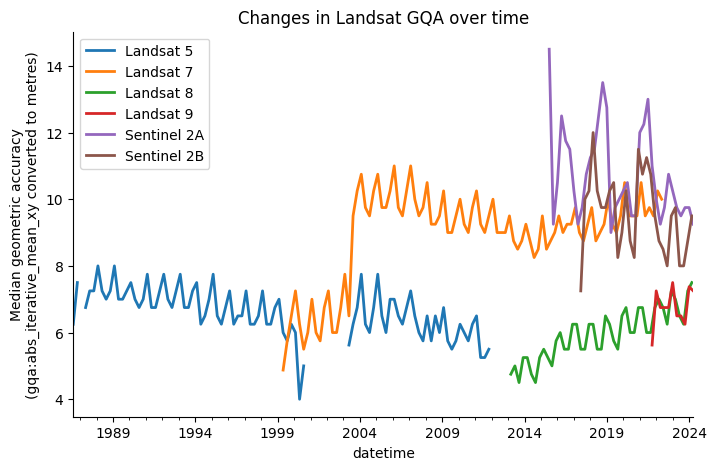

In [60]:
plt.figure(figsize=(8, 5))
# metadata_df.set_index('datetime').resample('3M').mean()['hour'].plot(c='black', linewidth=0.2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-5', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 5').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-7', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 7').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-8', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 8').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'landsat-9', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 9').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'sentinel-2a', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Sentinel 2A').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'sentinel-2b', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Sentinel 2B').plot(legend=True, lw=2)
plt.ylabel("Median geometric accuracy\n(gqa:abs_iterative_mean_xy converted to metres)")
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title("Changes in Landsat GQA over time")
plt.savefig("gqa_over_time.png")

In [84]:
metadata_subset.loc[metadata_subset['eo:platform'] == 'sentinel-2b', ["datetime", "gqa:abs_iterative_mean_xy"]]

,datetime,gqa:abs_iterative_mean_xy


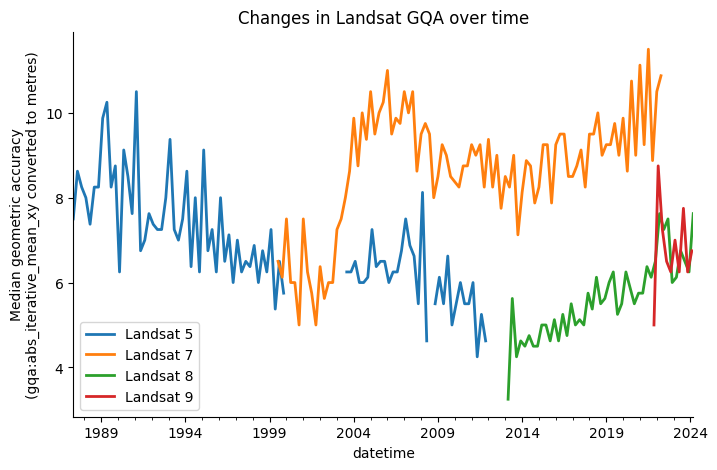

In [85]:
plt.figure(figsize=(8, 5))
metadata_subset = metadata_df.loc[metadata_df['odc:region_code'].isin(['089083', '089084', '090083', '090084'])]

metadata_subset.loc[metadata_subset['eo:platform'] == 'landsat-5', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 5').plot(legend=True, lw=2)
metadata_subset.loc[metadata_subset['eo:platform'] == 'landsat-7', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 7').plot(legend=True, lw=2)
metadata_subset.loc[metadata_subset['eo:platform'] == 'landsat-8', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 8').plot(legend=True, lw=2)
metadata_subset.loc[metadata_subset['eo:platform'] == 'landsat-9', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Landsat 9').plot(legend=True, lw=2)
# metadata_subset.loc[metadata_subset['eo:platform'] == 'sentinel-2a', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Sentinel 2A').plot(legend=True, lw=2)
# metadata_subset.loc[metadata_subset['eo:platform'] == 'sentinel-2b', ["datetime", "gqa:abs_iterative_mean_xy"]].set_index('datetime').resample('3M').median()["gqa:abs_iterative_mean_xy"].rename('Sentinel 2B').plot(legend=True, lw=2)
plt.ylabel("Median geometric accuracy\n(gqa:abs_iterative_mean_xy converted to metres)")
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title("Changes in Landsat GQA over time")
plt.savefig("gqa_over_time.png")

In [57]:
import geopandas as gpd

In [76]:
borders = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp").to_crs("EPSG:4326").query("FEAT_CODE == 'coastline'").simplify(0.5)

/tmp/ipykernel_338/4228926321.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_df.groupby("odc:region_code").median().rename({"gqa:abs_iterative_mean_xy": new_legend_name}, axis=1).plot.scatter(


<Axes: xlabel='lon', ylabel='lat'>

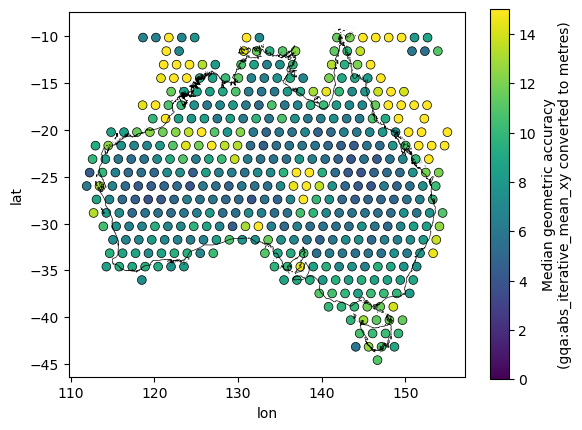

In [84]:
import matplotlib.pyplot as plt

new_legend_name = "Median geometric accuracy\n(gqa:abs_iterative_mean_xy converted to metres)"

ax1 = borders.plot(linewidth=0.5, color="black")
metadata_df.groupby("odc:region_code").median().rename({"gqa:abs_iterative_mean_xy": new_legend_name}, axis=1).plot.scatter(
    x="lon",
    y="lat",
    c=new_legend_name,
    vmin=0,
    vmax=15,
    s=40,
    edgecolor="black",
    linewidth=0.5,
    ax=ax1,
)


/tmp/ipykernel_338/686897626.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metadata_df.groupby("odc:region_code").mean().plot.scatter(


<Axes: xlabel='lon', ylabel='lat'>

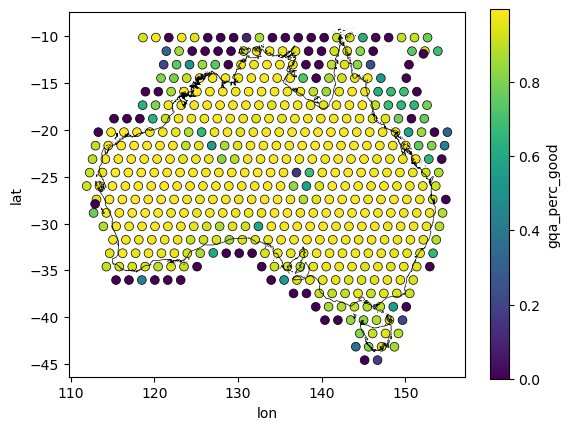

In [81]:
import matplotlib.pyplot as plt

borders.plot(linewidth=0.5, color="black")
metadata_df.groupby("odc:region_code").mean().plot.scatter(
    x="lon",
    y="lat",
    c="gqa_perc_good",
    s=40,
    edgecolor="black",
    linewidth=0.5,
    ax=plt.gca()
)



<Axes: xlabel='datetime'>

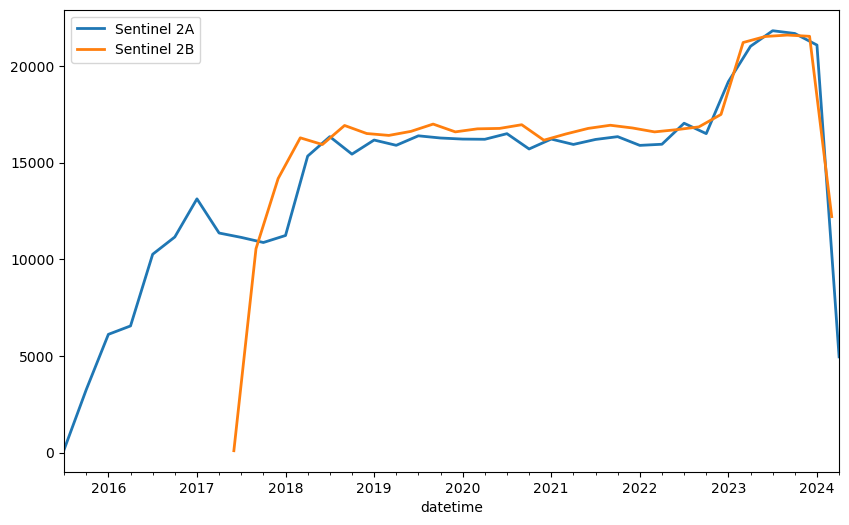

In [45]:
plt.figure(figsize=(10, 6))
# metadata_df.set_index('datetime').resample('3M').count()['hour'].iloc[0:-1].plot(c='black', linewidth=0.5)
# metadata_df.loc[metadata_df['eo:platform'] == 'landsat-5'].set_index('datetime').resample('3M').count()['hour'].rename('Landsat 5').plot(legend=True, lw=2)
# metadata_df.loc[metadata_df['eo:platform'] == 'landsat-7'].set_index('datetime').resample('3M').count()['hour'].rename('Landsat 7').plot(legend=True, lw=2)
# metadata_df.loc[metadata_df['eo:platform'] == 'landsat-8'].set_index('datetime').resample('3M').count()['hour'].rename('Landsat 8').plot(legend=True, lw=2)
# metadata_df.loc[metadata_df['eo:platform'] == 'landsat-9'].set_index('datetime').resample('3M').count()['hour'].rename('Landsat 9').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'sentinel-2a'].set_index('datetime').resample('3M').count()['hour'].rename('Sentinel 2A').plot(legend=True, lw=2)
metadata_df.loc[metadata_df['eo:platform'] == 'sentinel-2b'].set_index('datetime').resample('3M').count()['hour'].rename('Sentinel 2B').plot(legend=True, lw=2)
# plt.gca().set_xlim(2015, 2024)

In [173]:
metadata_yearly_df = metadata_df.query("`eo:cloud_cover` < 50").set_index('datetime').groupby('odc:region_code').resample('1Y').count()

In [177]:
metadata_yearly_df = metadata_yearly_df.drop('odc:region_code', axis=1).reset_index().astype(int)
metadata_yearly_df['datetime'] = pd.to_datetime(metadata_yearly_df['datetime'])

/tmp/ipykernel_108/1504016061.py:1: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  metadata_yearly_df = metadata_yearly_df.drop('odc:region_code', axis=1).reset_index().astype(int)


In [178]:
import geopandas as gpd

wrs_gdf = gpd.read_file('https://data.dea.ga.gov.au/derivative/ga_ls_path_row_grid.geojson')
wrs_gdf

wrs_joined_gdf = wrs_gdf.merge(metadata_yearly_df, left_on='PR', right_on='odc:region_code')

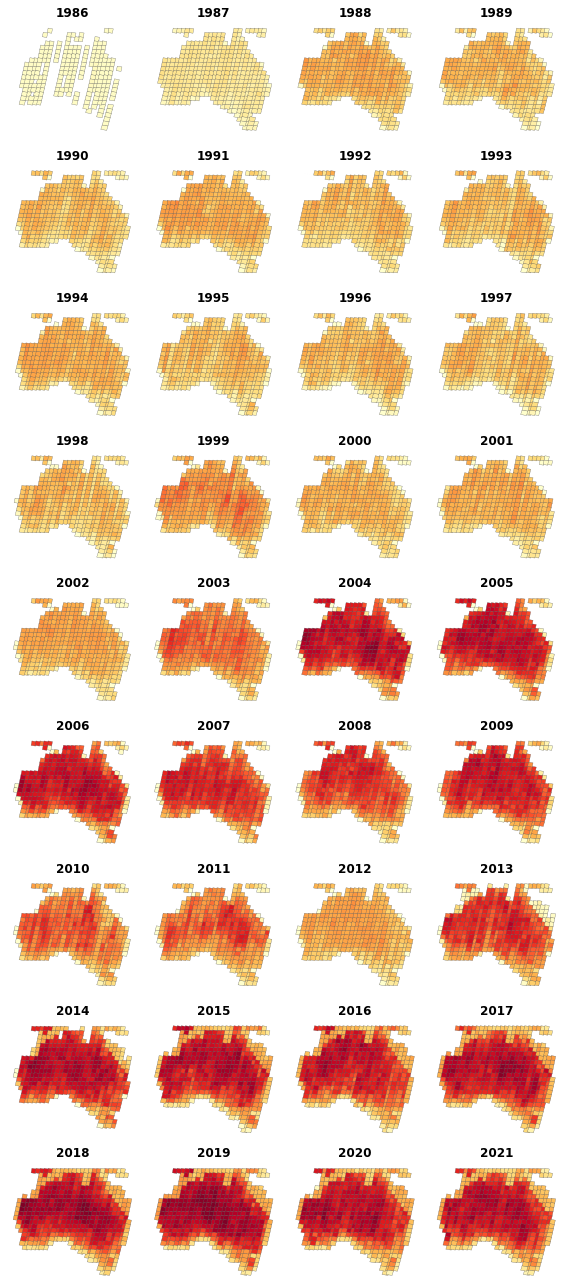

In [182]:
fig, axes = plt.subplots(
    ncols=4, nrows=9, sharex=True, sharey=True
)  # Create the plot figure and axes
axes = axes.flatten()
fig.set_size_inches(8, 18)

years = sorted(wrs_joined_gdf.datetime.dt.year.unique())


for i, year in enumerate(years[:-1]):
    wrs_joined_gdf.loc[wrs_joined_gdf.datetime.dt.year == year].plot(
        ax=axes[i],
        column="hour",
        vmin=0,
        vmax=45,
        cmap="YlOrRd",
        edgecolor="#5c5c5c",
        linewidth=0.3,
    )
    axes[i].axis('off')
    axes[i].set_title(year, fontweight='bold')
    
fig.tight_layout()

In [289]:
def local_time_lat(lat):
    """
    Estimates indicative local overpass times for Landsat 5 
    and 7 based on latitude.
    
    This estimate is based on a polynomial relationship found
    by Zhang et al. 2016, derived from Landsat 5 and 7 data 
    acquired from 2010-12-1 to 2011-11-30. Overpass times
    increase with increasing latitude.

    Zhang, H.K., Roy, D.P., Kovalskyy, V., 2016. Optimal solar
    geometry definition for globallong term Landsat time series
    bi-directional reflectance normalization. IEEE Trans.Geosci.
    Remote Sens. 54 (3), 1410–1418.
    http://dx.doi.org/10.1109/TGRS.2015.2480684.233
    """
    return (
        0.00000000136292 * lat ** 5
        - 0.0000000315403 * lat ** 4
        - 0.00000315819614 * lat ** 3
        + 0.0000652685643 * lat ** 2
        + 0.01120604786763 * lat
        + 10.06
    )

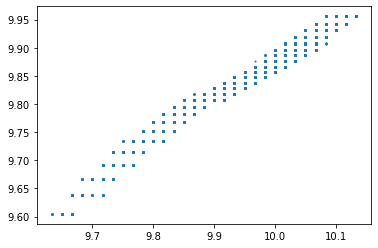

In [274]:
import matplotlib.pyplot as plt
plt.scatter(metadata_df.loc[metadata_df['eo:platform'] == 'landsat-8'].hour, lt_lat(metadata_df.loc[metadata_df['eo:platform'] == 'landsat-8'].lat), s=1)


In [136]:
# from timezonefinder import TimezoneFinder
# tf = TimezoneFinder()
# metadata_df['timezone'] = metadata_df.apply(lambda x: tf.certain_timezone_at(lng=x.lon, lat=x.lat), axis=1)

In [100]:
# from timezonefinder import TimezoneFinder

# tf = TimezoneFinder()  # reuse

# tf.timezone_at(lng=metadata_df.iloc[100].lon, lat=metadata_df.iloc[100].lat)  # 'Europe/Berlin'

'Etc/GMT-8'

In [216]:
metadata_df['datetime'][0] + dt.timedelta(150/15)

Timestamp('2022-04-14 00:06:15.125311+0000', tz='UTC')

In [222]:
180/12

15.0

In [220]:
metadata_df['datetime'][0].hour + (metadata_df['datetime'][0].minute/60) + 150/15

10.1

In [113]:
# tf.certain_timezone_at(lng=metadata_df.iloc[-100].lon, lat=metadata_df.iloc[-100].lat)

'Etc/GMT-10'

In [134]:
# metadata_df['datetime_local'] = metadata_df.apply(lambda x: x.datetime.tz_convert(x.timezone), axis=1)

In [139]:
metadata_df

,eo:gsd,datetime,gqa:abs_x,gqa:abs_y,gqa:cep90,proj:epsg,fmask:snow,gqa:abs_xy,gqa:mean_x,gqa:mean_y,...,landsat:landsat_scene_id,gqa:abs_iterative_mean_xy,landsat:collection_number,landsat:landsat_product_id,landsat:collection_category,proj:transform,lat,lon,timezone,datetime_local
0,30.0,2006-01-25 02:12:51.471000+00:00,1.05,1.34,1.17,32649,0.000008,1.71,-0.53,0.52,...,LT51150792006025ASA00,0.65,1,LT05_L1TP_115079_20060125_20181115_01_T2,T2,NaN,-27.433026,113.112621,Etc/GMT-8,2006-01-25 10:12:51.471000+08:00
1,30.0,2006-08-05 02:16:06.296019+00:00,0.2,0.27,0.42,32649,0.001749,0.33,-0.04,0.23,...,LT51150792006217ASA00,0.25,1,LT05_L1TP_115079_20060805_20161119_01_T1,T1,"[30.0, 0.0, 587085.0, 0.0, -30.0, -2929485.0, ...",-27.432263,113.095486,Etc/GMT-8,2006-08-05 10:16:06.296019+08:00
2,30.0,2007-07-07 02:16:31.918081+00:00,0.18,0.3,0.43,32649,0.000000,0.35,-0.12,-0.03,...,LT51150792007188ASA00,0.21,1,LT05_L1TP_115079_20070707_20161113_01_T1,T1,"[30.0, 0.0, 590985.0, 0.0, -30.0, -2931285.0, ...",-27.450240,113.132171,Etc/GMT-8,2007-07-07 10:16:31.918081+08:00
3,30.0,2006-10-08 02:16:52.651063+00:00,0.18,0.24,0.32,32649,0.000226,0.3,-0.11,0.08,...,LT51150792006281ASA00,0.17,1,LT05_L1TP_115079_20061008_20161118_01_T1,T1,"[30.0, 0.0, 585285.0, 0.0, -30.0, -2929485.0, ...",-27.432065,113.072784,Etc/GMT-8,2006-10-08 10:16:52.651063+08:00
4,30.0,2005-09-19 02:10:56.500081+00:00,0.13,0.19,0.29,32649,0.000148,0.23,-0.05,0.17,...,LT51150792005262ASA01,0.17,1,LT05_L1TP_115079_20050919_20161125_01_T1,T1,"[30.0, 0.0, 582585.0, 0.0, -30.0, -2928285.0, ...",-27.421031,113.052846,Etc/GMT-8,2005-09-19 10:10:56.500081+08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129898,30.0,1990-12-17 22:55:48.680038+00:00,0.87,0.93,1.5,32656,0.000000,1.27,0.17,0.06,...,LT50880801990351ASA00,0.7,1,LT05_L1TP_088080_19901217_20181108_01_T1,T1,"[30.0, 0.0, 518985.0, 0.0, -30.0, -3085065.0, ...",-28.841334,154.396833,Etc/GMT-10,1990-12-18 08:55:48.680038+10:00
129899,30.0,1987-09-20 23:03:19.401056+00:00,0.71,0.89,0.96,32656,0.000000,1.14,-0.13,0.05,...,LT50880801987263ASA00,0.52,1,LT05_L1TP_088080_19870920_20181105_01_T2,T2,"[30.0, 0.0, 523365.0, 0.0, -30.0, -3087645.0, ...",-28.860142,154.444781,Etc/GMT-10,1987-09-21 09:03:19.401056+10:00
129900,30.0,1991-08-30 23:00:01.691056+00:00,0.6,0.56,0.79,32656,0.000000,0.82,-0.07,-0.06,...,LT50880801991242ASA00,0.43,1,LT05_L1TP_088080_19910830_20181108_01_T1,T1,"[30.0, 0.0, 519675.0, 0.0, -30.0, -3086055.0, ...",-28.850300,154.402939,Etc/GMT-10,1991-08-31 09:00:01.691056+10:00
129901,30.0,1988-08-21 23:07:05.976025+00:00,0.69,1.09,0.98,32656,0.000003,1.29,-0.14,0.04,...,LT50880801988234ASA00,0.53,1,LT05_L1TP_088080_19880821_20181107_01_T1,T1,"[30.0, 0.0, 521625.0, 0.0, -30.0, -3087465.0, ...",-28.860101,154.424843,Etc/GMT-10,1988-08-22 09:07:05.976025+10:00


<AxesSubplot:xlabel='lon', ylabel='lat'>

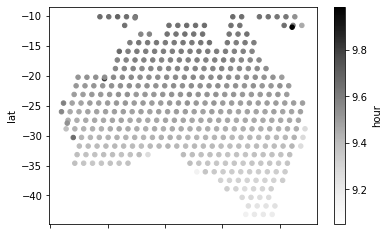

In [167]:
import math
from datetime import timedelta


# utc_dt + 


metadata_df['datetime'] + timedelta(hours=150 / math.pi * 12)

0        2006-02-17 23:10:19.533471+00:00
1        2006-08-28 23:13:34.358490+00:00
2        2007-07-30 23:13:59.980552+00:00
3        2006-10-31 23:14:20.713534+00:00
4        2005-10-12 23:08:24.562552+00:00
                       ...               
129898   1991-01-10 19:53:16.742509+00:00
129899   1987-10-14 20:00:47.463527+00:00
129900   1991-09-23 19:57:29.753527+00:00
129901   1988-09-14 20:04:34.038496+00:00
129902   1990-12-25 19:53:00.306484+00:00
Name: datetime, Length: 129903, dtype: datetime64[ns, UTC]

In [174]:
metadata_df['datetime']+dt.timedelta(hours=(metadata_df['lon']*12/180))

TypeError: unsupported type for timedelta hours component: Series

In [168]:
timedelta(hours=150 / math.pi * 12)

datetime.timedelta(days=23, seconds=75448, microseconds=62471)

In [155]:
metadata_df['odc:region_code']

0         115079
1         115079
2         115079
3         115079
4         115079
           ...  
129898    088080
129899    088080
129900    088080
129901    088080
129902    088080
Name: odc:region_code, Length: 129903, dtype: object

In [114]:
metadata_df['datetime'].dt.tz_convert('Etc/GMT-10')

0        2006-01-25 12:12:51.471000+10:00
1        2006-08-05 12:16:06.296019+10:00
2        2007-07-07 12:16:31.918081+10:00
3        2006-10-08 12:16:52.651063+10:00
4        2005-09-19 12:10:56.500081+10:00
                       ...               
129898   1990-12-18 08:55:48.680038+10:00
129899   1987-09-21 09:03:19.401056+10:00
129900   1991-08-31 09:00:01.691056+10:00
129901   1988-08-22 09:07:05.976025+10:00
129902   1990-12-02 08:55:32.244013+10:00
Name: datetime, Length: 129903, dtype: datetime64[ns, Etc/GMT-10]

In [130]:
metadata_df[['datetime', 'datetime_local', 'lat', 'lon']]

,datetime,datetime_local,lat,lon
0,2006-01-25 02:12:51.471000+00:00,2006-01-25 10:12:51.471000+08:00,-27.433026,113.112621
1,2006-08-05 02:16:06.296019+00:00,2006-08-05 10:16:06.296019+08:00,-27.432263,113.095486
2,2007-07-07 02:16:31.918081+00:00,2007-07-07 10:16:31.918081+08:00,-27.450240,113.132171
3,2006-10-08 02:16:52.651063+00:00,2006-10-08 10:16:52.651063+08:00,-27.432065,113.072784
4,2005-09-19 02:10:56.500081+00:00,2005-09-19 10:10:56.500081+08:00,-27.421031,113.052846
...,...,...,...,...
129898,1990-12-17 22:55:48.680038+00:00,1990-12-18 08:55:48.680038+10:00,-28.841334,154.396833
129899,1987-09-20 23:03:19.401056+00:00,1987-09-21 09:03:19.401056+10:00,-28.860142,154.444781
129900,1991-08-30 23:00:01.691056+00:00,1991-08-31 09:00:01.691056+10:00,-28.850300,154.402939
129901,1988-08-21 23:07:05.976025+00:00,1988-08-22 09:07:05.976025+10:00,-28.860101,154.424843


In [132]:
metadata_df['datetime_local']  #.dt.time

0         2006-01-25 10:12:51.471000+08:00
1         2006-08-05 10:16:06.296019+08:00
2         2007-07-07 10:16:31.918081+08:00
3         2006-10-08 10:16:52.651063+08:00
4         2005-09-19 10:10:56.500081+08:00
                        ...               
129898    1990-12-18 08:55:48.680038+10:00
129899    1987-09-21 09:03:19.401056+10:00
129900    1991-08-31 09:00:01.691056+10:00
129901    1988-08-22 09:07:05.976025+10:00
129902    1990-12-02 08:55:32.244013+10:00
Name: datetime_local, Length: 129903, dtype: object

In [104]:
metadata_df.iloc[100].lat

-27.435203141040112

In [98]:
metadata_df.iloc[0].lon

113.1126209098012

In [90]:



# tz = tzwhere.tzwhere()

# tz.tzNameAt(metadata_df.iloc[0].lat, metadata_df.iloc[0].lon, forceTZ=True)

AssertionError: You need to initialize tzwhere with forceTZ

In [87]:
metadata_df.iloc[0].lat

-27.433026072915435

In [44]:
metadata_df.datetime.dt.time

0         02:12:51.471000
1         02:16:06.296019
2         02:16:31.918081
3         02:16:52.651063
4         02:10:56.500081
               ...       
129898    22:55:48.680038
129899    23:03:19.401056
129900    23:00:01.691056
129901    23:07:05.976025
129902    22:55:32.244013
Name: datetime, Length: 129903, dtype: object

In [47]:
pip install tzwhere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for tzwhere: filename=tzwhere-3.0.3-py3-none-any.whl size=23742599 sha256=3e5b34c7ff887f8f303dae0fbbe47805894c5ed7af64e95f68f52d0c7ddde5f4
  Stored in directory: /home/jovyan/.cache/pip/wheels/7f/bf/d2/ab40d8a9e80a922d5a19a00a71f8c660c286ced08e3b427d65
Successfully built tzwhere
You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


America/Chicago


In [50]:
(tz.tzNameAt(35.29, -89.66)

<module 'tzwhere.tzwhere' from '/env/lib/python3.8/site-packages/tzwhere/tzwhere.py'>

In [27]:
dss[0].metadata_doc['properties']

{'eo:gsd': 30.0,
 'datetime': '2006-01-25T02:12:51.471000Z',
 'gqa:abs_x': 1.05,
 'gqa:abs_y': 1.34,
 'gqa:cep90': 1.17,
 'proj:epsg': 32649,
 'fmask:snow': 7.761912543530099e-06,
 'gqa:abs_xy': 1.71,
 'gqa:mean_x': -0.53,
 'gqa:mean_y': 0.52,
 'proj:shape': [7123, 8063],
 'eo:platform': 'landsat-5',
 'fmask:clear': 3.2629372712240956,
 'fmask:cloud': 27.77631968813256,
 'fmask:water': 58.91383469837778,
 'gqa:mean_xy': 0.74,
 'odc:product': 'ga_ls5t_ard_3',
 'gqa:stddev_x': 1.69,
 'gqa:stddev_y': 2.57,
 'odc:producer': 'ga.gov.au',
 'eo:instrument': 'TM',
 'gqa:stddev_xy': 3.07,
 'eo:cloud_cover': 27.77631968813256,
 'eo:sun_azimuth': 83.97054419,
 'landsat:wrs_row': 79,
 'odc:file_format': 'GeoTIFF',
 'odc:region_code': '115079',
 'dtr:end_datetime': '2006-01-25T02:13:04.961715Z',
 'eo:sun_elevation': 55.34726883,
 'landsat:wrs_path': 115,
 'dtr:start_datetime': '2006-01-25T02:12:37.871493Z',
 'fmask:cloud_shadow': 10.046900580353025,
 'odc:product_family': 'ard',
 'odc:dataset_versi

In [26]:
{k: v for k, v in dss[0].metadata_doc['properties'].items() if len(v) >= 2}

TypeError: object of type 'float' has no len()